In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cpu device


In [3]:
List = pickle.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Hodgkin Huxley population/datarun_' + str(2), 'rb'))
[N, C_E, C_I, EI, IE, resolution, T, dt, T_step, spikes_true, spikes_train, spike_thres, I_inj, V] = List

spike_thres = np.flip(np.sort(spikes_train.ravel()))[int(np.ceil(0.15*(spikes_train.shape[0]*spikes_train.shape[1])))]
data = torch.tensor(1.0 * (spikes_train > spike_thres))

# Surrogate HH data with random connectivity

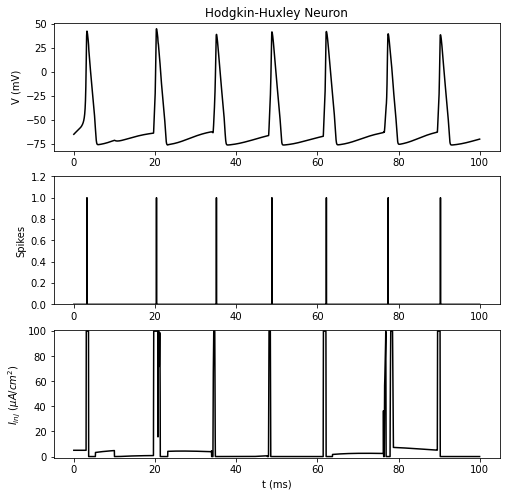

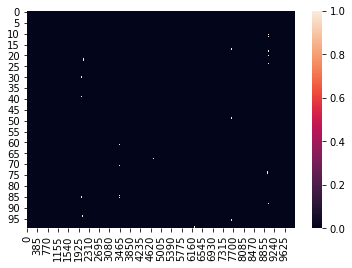

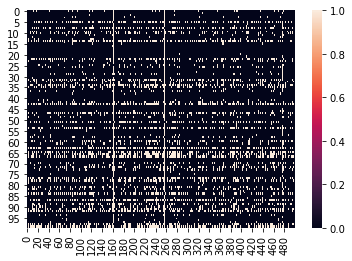

In [3]:
time = int(100/dt)
n = torch.randperm(N)[0]
fig, ax = plt.subplots(3, 1, figsize=(8, 8))
ax[0].set_title('Hodgkin-Huxley Neuron')
ax[0].plot(T_steps[:time], V[n, :time], 'k')
ax[0].set_ylabel('V (mV)')

ax[1].plot(T_steps[:time], spikes_true[n, :time], 'k')
ax[1].set_ylabel('Spikes')
ax[1].set_ylim(0, 1.2)

ax[2].plot(T_steps[:time], I_inj[n, :time], 'k')
ax[2].set_xlabel('t (ms)')
ax[2].set_ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
ax[2].set_ylim(-1, 101)
plt.show()

#sns.heatmap(I_inj)
#plt.show()

sns.heatmap(spikes_true[:, :10000])
plt.show()
#spike_thres = np.flip(np.sort(spikes_train.ravel()))[int(np.ceil(0.15*(spikes_train.shape[0]*spikes_train.shape[1])))]

sns.heatmap(data)
plt.show()



# Train RTRBM

In [4]:
n_epochs = 1000
N_H = 2
N_V, T = data.shape
data1 = data[torch.sum(data,1)!=0, :]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.21it/s]


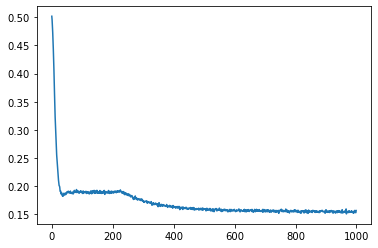

In [5]:
rtrbm = RTRBM(data1, N_H=N_H, device = device)
rtrbm.learn(n_epochs=n_epochs, lr=1e-4, lr_end=1e-5, start_decay=100, sp=None, x=2, batchsize=10, disable_tqdm = False)

plt.plot(rtrbm.errors)

# Sort visibles

In [6]:
corr = np.zeros((N_V, N_V))
shuffle_idx = np.zeros((N_V))
for i in range(N_V):
    for j in range(N_V):
        corr[i, j] = np.correlate(data[i,:], data[j,:])
    shuffle_idx[i] = np.argmax(corr[i,:])
    
#HH = rtrbm.W_acc[shuffle_idx, :]    
#HH = HH[:, shuffle_idx]
HH = rtrbm.W_acc
VH = rtrbm.W[:, shuffle_idx]    

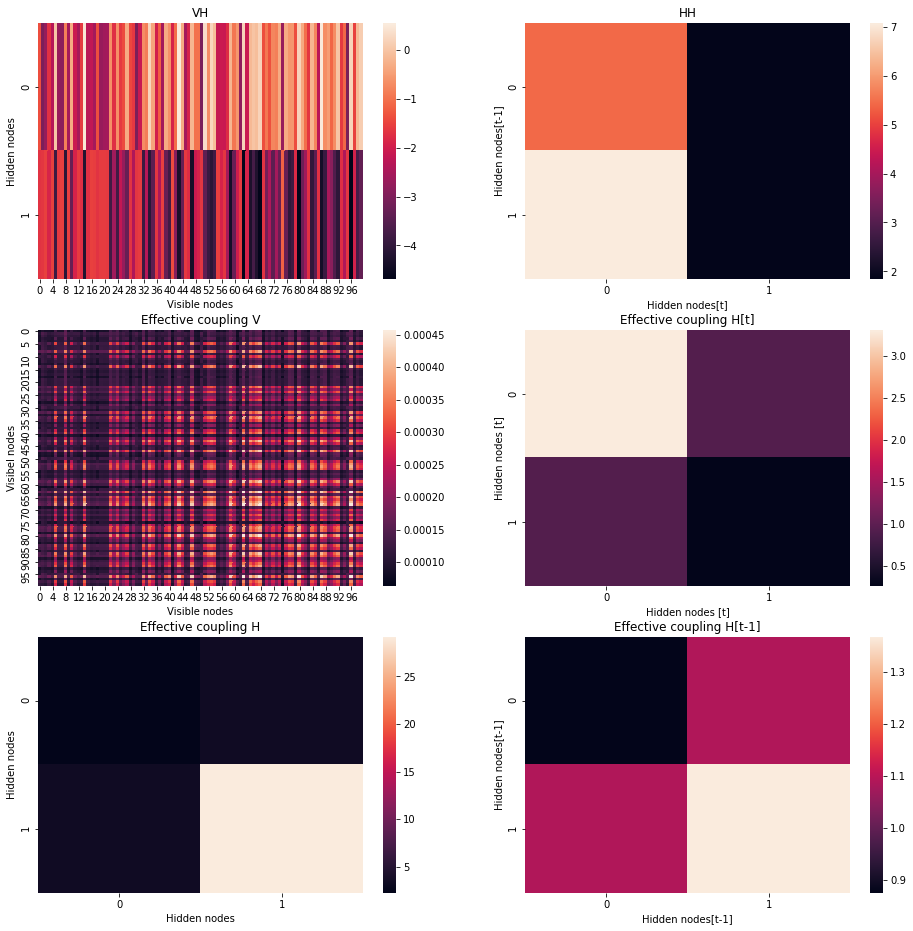

In [7]:
h = rtrbm.visible_to_expected_hidden(data.float())
plot_effective_coupling_VH_HH(VH, HH, data.float(), h) 

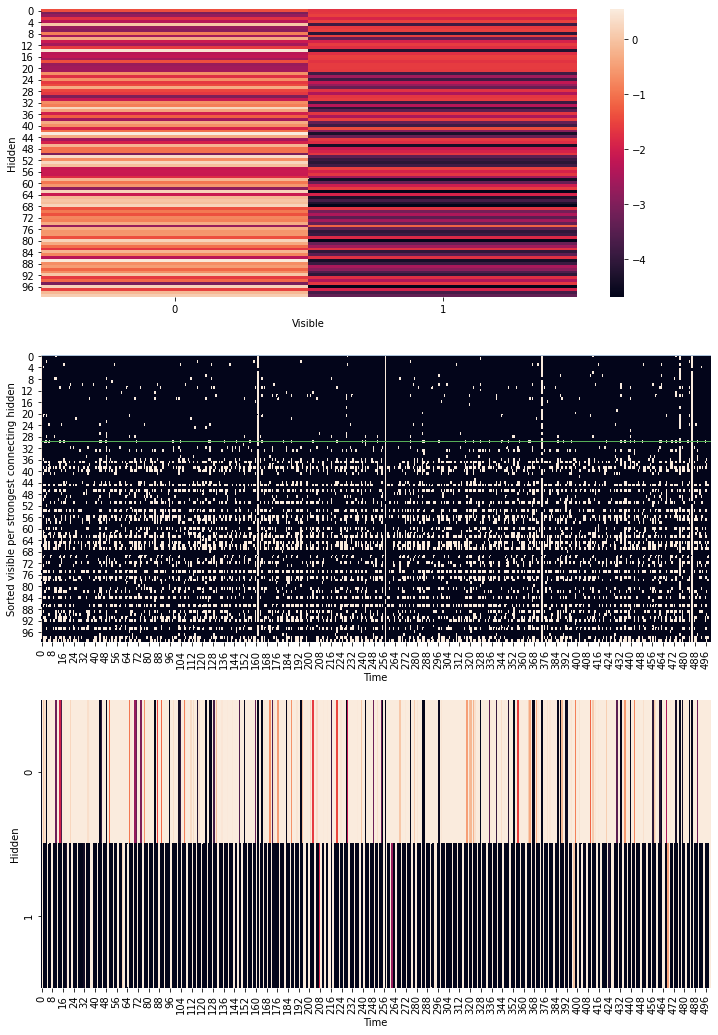

In [18]:
VH = VH
V = data.float()
H = h
colors_list = list(colors._colors_full_map.values())
N_V, T = V.shape
N_H = H.shape[0]

stongest_connecting_HU = torch.zeros(N_V)
for i in range(N_V):
    # returns the index of the strongest connecting HU per visible, according to VH
    stongest_connecting_HU[i] = torch.argmax(torch.abs(VH[:,i]))

# sort visibles to their strongest connection HU
idx = torch.argsort(stongest_connecting_HU)
num = torch.zeros(N_H+1, dtype=int)
for i in range(N_H):
    # determine how many visibles are connected to hidden i
    num[i+1] = num[i] + torch.count_nonzero(stongest_connecting_HU == i)

fig, ax = plt.subplots(3,1, figsize=(12,18))
sns.heatmap(VH.T, ax=ax[0])
ax[0].set_xlabel('Visible')
ax[0].set_ylabel('Hidden')

sns.heatmap(V[idx,:], ax = ax[1], cbar=False)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Sorted visible per strongest connecting hidden')

for x, i in enumerate(num):
    ax[1].hlines(i, 0, T, colors = colors_list[x],linewidth=1)

sns.heatmap(H, ax = ax[2], cbar=False)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Hidden')

plt.show()

In [24]:
torch.sum(idx[:30] < 30)

tensor(14)

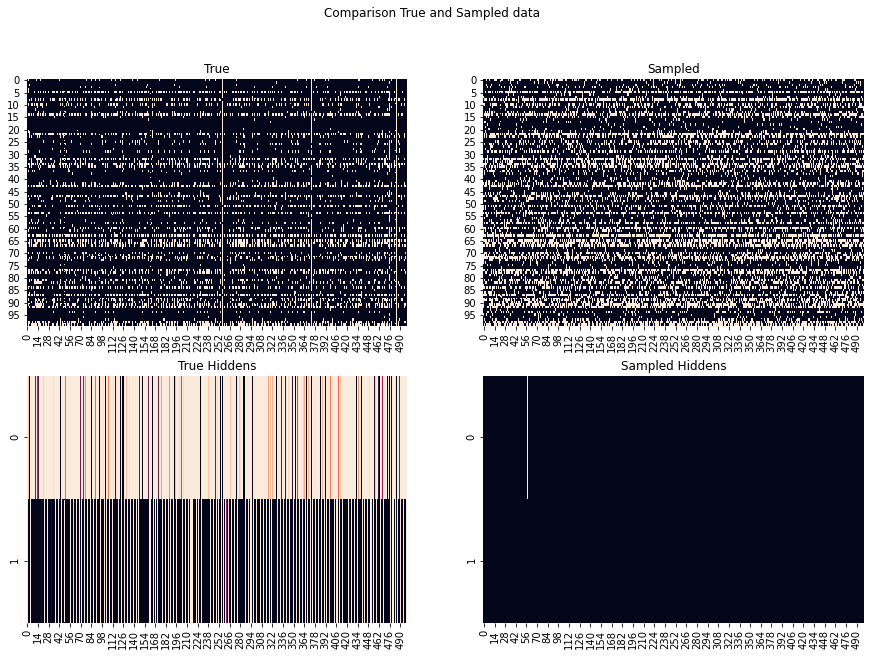

In [9]:
idx = np.random.randint(0.1 * T)
vt_infer, rt_infer = rtrbm.sample(data[:, idx].float(), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
plot_true_sampled(data, h, vt_infer, rt_infer)

C:\Users\Sebastian\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\Sebastian\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Sebastian\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


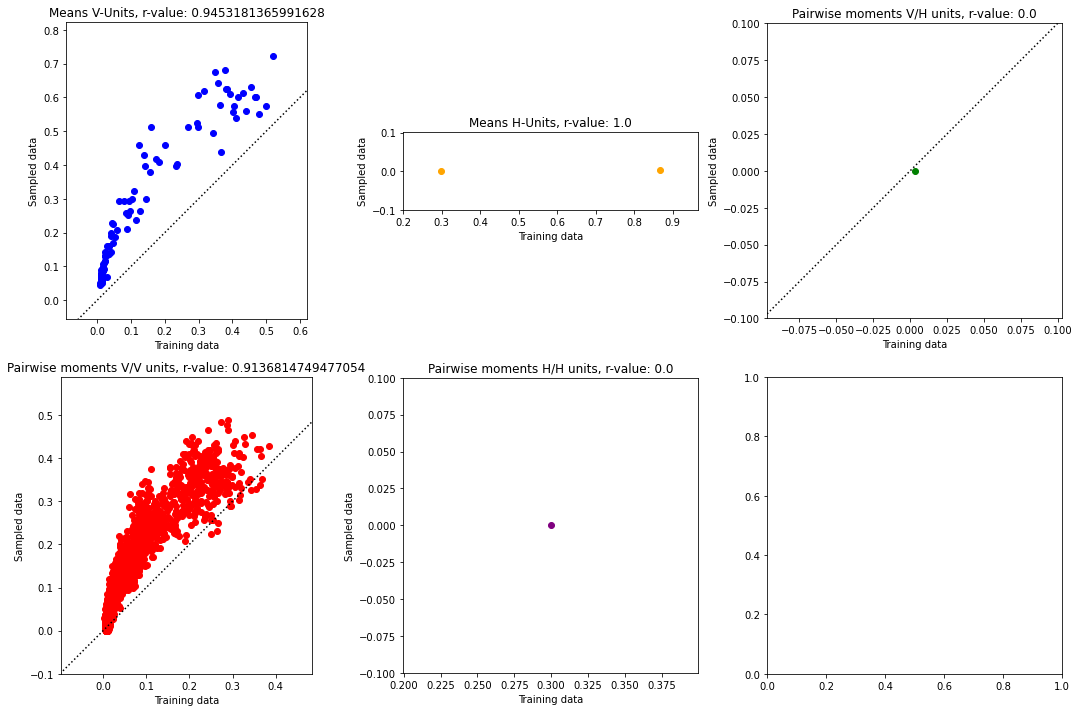

In [10]:
plot_moments(data.float(), h.float(), vt_infer, rt_infer)

# Resolution

In [3]:
List1 = pickle.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Hodgkin Huxley population/res_spikes_' + str(0), 'rb'))
[spikes_r5, spikes_r10, spikes_r20, spikes_r50, spikes_r100, spikes_r200, spikes_r500] = List1

theta = 0.15

spike_thres_r5 = np.flip(np.sort(spikes_r5.ravel()))[int(np.ceil(theta*(spikes_r5.shape[0]*spikes_r5.shape[1])))]
spike_thres_r10 = np.flip(np.sort(spikes_r10.ravel()))[int(np.ceil(theta*(spikes_r10.shape[0]*spikes_r10.shape[1])))]
spike_thres_r20 = np.flip(np.sort(spikes_r20.ravel()))[int(np.ceil(theta*(spikes_r20.shape[0]*spikes_r20.shape[1])))]
spike_thres_r50 = np.flip(np.sort(spikes_r50.ravel()))[int(np.ceil(theta*(spikes_r50.shape[0]*spikes_r50.shape[1])))]
spike_thres_r100 = np.flip(np.sort(spikes_r100.ravel()))[int(np.ceil(theta*(spikes_r100.shape[0]*spikes_r100.shape[1])))]
spike_thres_r200 = np.flip(np.sort(spikes_r200.ravel()))[int(np.ceil(theta*(spikes_r200.shape[0]*spikes_r200.shape[1])))]
spike_thres_r500 = np.flip(np.sort(spikes_r500.ravel()))[int(np.ceil(theta*(spikes_r500.shape[0]*spikes_r500.shape[1])))]


Text(42.0, 0.5, 'Spikes 2Hz')

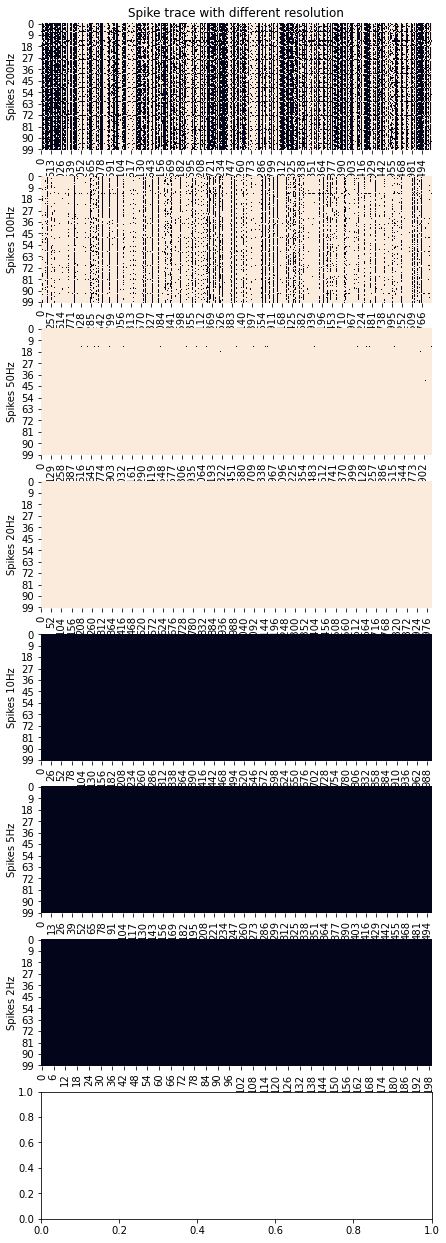

In [12]:
fig, ax = plt.subplots(8, 1, figsize=(7, 22))
ax[0].set_title('Spike trace with different resolution')
sns.heatmap(spikes_r5, cbar=False, ax=ax[0])
ax[0].set_ylabel('Spikes 200Hz')

sns.heatmap(spikes_r10, cbar=False, ax=ax[1])
ax[1].set_ylabel('Spikes 100Hz')

sns.heatmap(spikes_r20, cbar=False, ax=ax[2])
ax[2].set_ylabel('Spikes 50Hz')

sns.heatmap(spikes_r50, cbar=False, ax=ax[3])
ax[3].set_ylabel('Spikes 20Hz')

sns.heatmap(spikes_r100, cbar=False, ax=ax[4])
ax[4].set_ylabel('Spikes 10Hz')

sns.heatmap(spikes_r200, cbar=False, ax=ax[5])
ax[5].set_ylabel('Spikes 5Hz')

sns.heatmap(spikes_r500, cbar=False, ax=ax[6])
ax[6].set_ylabel('Spikes 2Hz')



<AxesSubplot:>

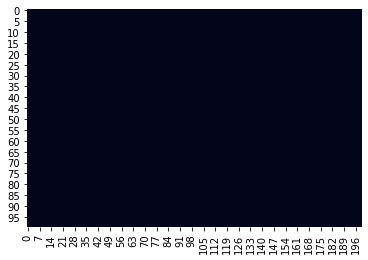

In [14]:
sns.heatmap(spikes_r500, cbar=False)


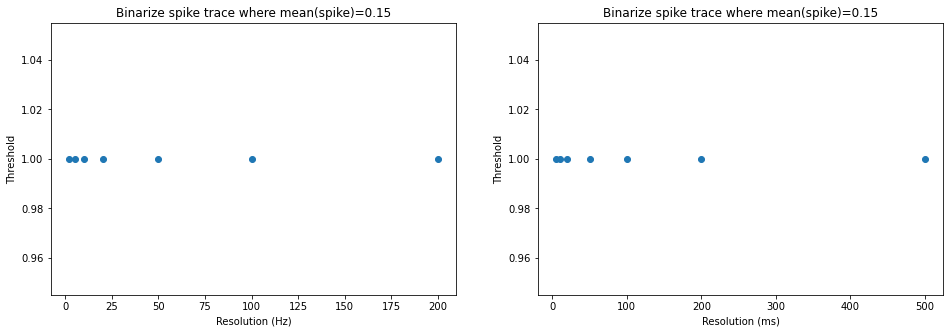

In [5]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].scatter([200, 100, 50, 20, 10, 5, 2], [spike_thres_r5, spike_thres_r10, spike_thres_r20, spike_thres_r50, spike_thres_r100, spike_thres_r200, spike_thres_r500] )
ax[0].set_xlabel('Resolution (Hz)')
ax[0].set_ylabel('Threshold')
ax[0].set_title('Binarize spike trace where mean(spike)={}'.format(theta))

ax[1].scatter([5, 10, 20, 50, 100, 200, 500], [spike_thres_r5, spike_thres_r10, spike_thres_r20, spike_thres_r50, spike_thres_r100, spike_thres_r200, spike_thres_r500] )
ax[1].set_xlabel('Resolution (ms)')
ax[1].set_ylabel('Threshold')
ax[1].set_title('Binarize spike trace where mean(spike)={}'.format(theta))
plt.show()

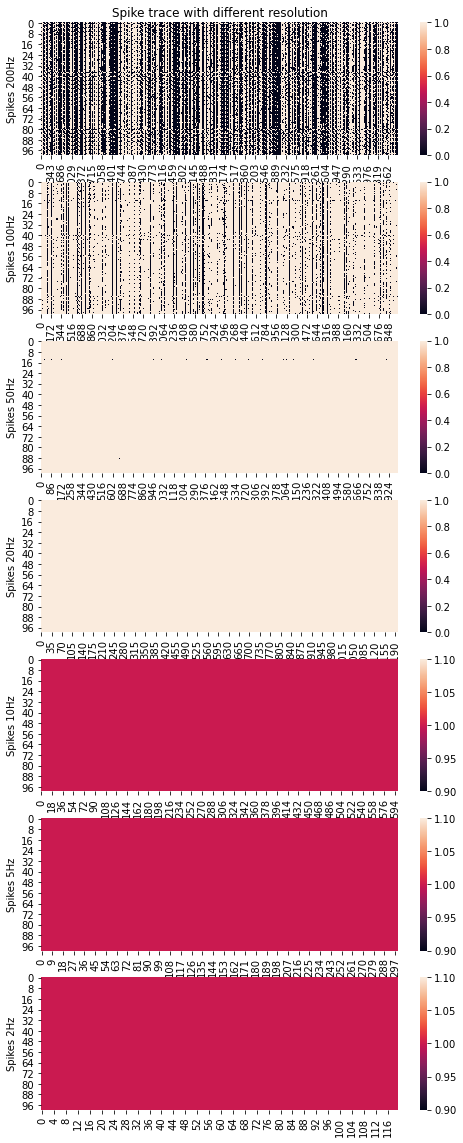

In [6]:
fig, ax = plt.subplots(7, 1, figsize=(8, 20))
ax[0].set_title('Spike trace with different resolution')
sns.heatmap(spikes_r5[:, :12000], ax=ax[0])
ax[0].set_ylabel('Spikes 200Hz')

sns.heatmap(spikes_r10[: , :6000], ax=ax[1])
ax[1].set_ylabel('Spikes 100Hz')

sns.heatmap(spikes_r20[: , :3000], ax=ax[2])
ax[2].set_ylabel('Spikes 50Hz')

sns.heatmap(spikes_r50[:, :1200], ax=ax[3])
ax[3].set_ylabel('Spikes 20Hz')

sns.heatmap(spikes_r100[:, :600], ax=ax[4])
ax[4].set_ylabel('Spikes 10Hz')

sns.heatmap(spikes_r200[:, :300], ax=ax[5])
ax[5].set_ylabel('Spikes 5Hz')

sns.heatmap(spikes_r500[:, :120], ax=ax[6])
ax[6].set_ylabel('Spikes 2Hz')
plt.show()

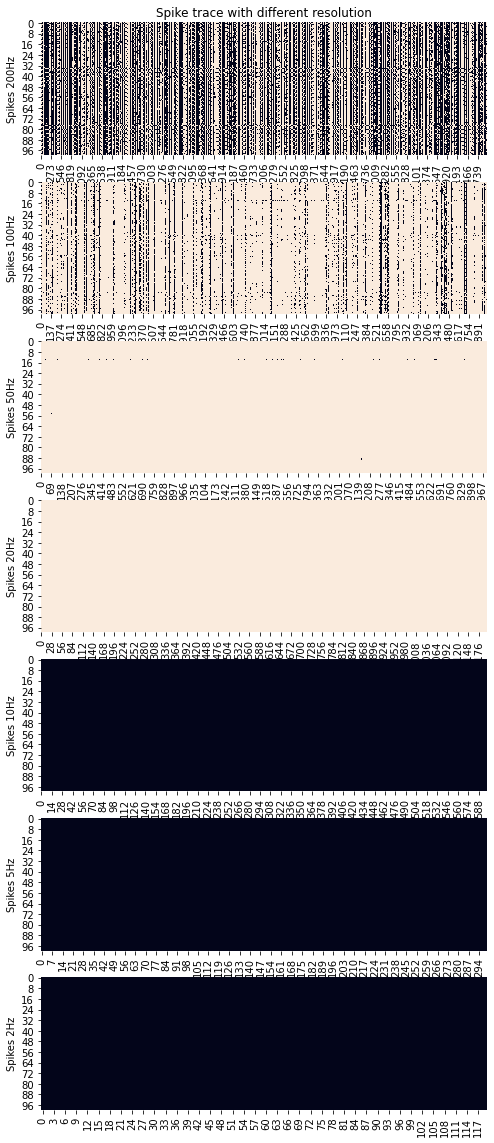

In [7]:
spike_thres = 0.5 * np.mean([spike_thres_r5, spike_thres_r10, spike_thres_r20, spike_thres_r50, spike_thres_r100, spike_thres_r200, spike_thres_r500])
fig, ax = plt.subplots(7, 1, figsize=(8, 20))
ax[0].set_title('Spike trace with different resolution')
sns.heatmap(1.0 * (spikes_r5[:, :12000] > spike_thres), cbar=False, ax=ax[0])
ax[0].set_ylabel('Spikes 200Hz')

sns.heatmap(1.0 * (spikes_r10[: , :6000] > spike_thres), cbar=False, ax=ax[1])
ax[1].set_ylabel('Spikes 100Hz')

sns.heatmap(1.0 * (spikes_r20[: , :3000] > spike_thres), cbar=False, ax=ax[2])
ax[2].set_ylabel('Spikes 50Hz')

sns.heatmap(1.0 * (spikes_r50[:, :1200] > spike_thres), cbar=False, ax=ax[3])
ax[3].set_ylabel('Spikes 20Hz')

sns.heatmap(1.0 * (spikes_r100[:, :600] > spike_thres), cbar=False, ax=ax[4])
ax[4].set_ylabel('Spikes 10Hz')

sns.heatmap(1.0 * (spikes_r200[:, :300] > spike_thres), cbar=False, ax=ax[5])
ax[5].set_ylabel('Spikes 5Hz')

sns.heatmap(1.0 * (spikes_r500[:, :120] > spike_thres), cbar=False, ax=ax[6])
ax[6].set_ylabel('Spikes 2Hz')
plt.show()

In [2]:
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools
import brian2 as b2

In [3]:
# Default parameters of a single LIF neuron:
V_REST = 0. * b2.mV
V_RESET = +10. * b2.mV
FIRING_THRESHOLD = +20. * b2.mV
MEMBRANE_TIME_SCALE = 20. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

# Default parameters of the network
SYNAPTIC_WEIGHT_W0 = 0.1 * b2.mV  # note: w_ee=w_ie = w0 and = w_ei=w_ii = -g*w0
RELATIVE_INHIBITORY_STRENGTH_G = 4.  # balanced
CONNECTION_PROBABILITY_EPSILON = 0.1
SYNAPTIC_DELAY = 1.5 * b2.ms
POISSON_INPUT_RATE = 12. * b2.Hz
N_POISSON_INPUT = 1000

(<Figure size 720x288 with 3 Axes>,
 <AxesSubplot:title={'center':'Raster Plot'}, ylabel='neuron #'>,
 <AxesSubplot:title={'center':'Population Activity'}, ylabel='A(t) [Hz]'>,
 <AxesSubplot:title={'center':'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

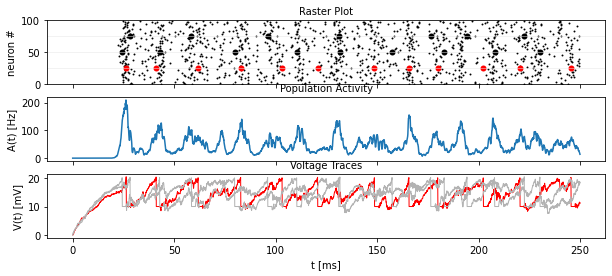

In [5]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=250. * b2.ms)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)



(<Figure size 720x288 with 3 Axes>,
 <AxesSubplot:title={'center':'Raster Plot'}, ylabel='neuron #'>,
 <AxesSubplot:title={'center':'Population Activity'}, ylabel='A(t) [Hz]'>,
 <AxesSubplot:title={'center':'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

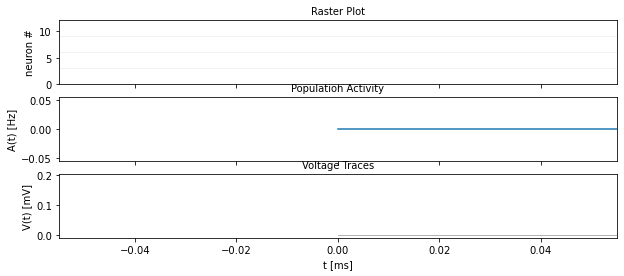

In [16]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(N_Excit=10, N_Inhib=2, N_extern=2, connection_probability=0.5)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)


In [4]:
for t in range(32, 0, -1):
    print(t)

32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
